# Load data

In [1]:
import datetime
import os

import IPython.display
import pandas as pd
import pandas.plotting
import numpy as np
import matplotlib as mpl
import matplotlib.cm
import matplotlib.pyplot as plt

inp_dir = "output"
celestial_objects = ["Sun", "Mercury", "Venus", "Earth", "Mars", "Jupiter", "Saturn", "Neptune", "Uranus", "Pluto"]
inp_fps = [ "output/pairwise_distances-SUN.csv",
            "output/pairwise_distances-MERCURY_BARYCENTER.csv",
            "output/pairwise_distances-VENUS_BARYCENTER.csv",
            "output/pairwise_distances-EARTH_BARYCENTER.csv",
            "output/pairwise_distances-MARS_BARYCENTER.csv",
            "output/pairwise_distances-JUPITER_BARYCENTER.csv",
            "output/pairwise_distances-SATURN_BARYCENTER.csv",
            "output/pairwise_distances-NEPTUNE_BARYCENTER.csv",
            "output/pairwise_distances-URANUS_BARYCENTER.csv",
            "output/pairwise_distances-PLUTO_BARYCENTER.csv"]

dist_from_sun = {}
dist_from_earth = {}
converters = {"DateTime" : lambda dt: datetime.datetime.strptime(dt, "%Y-%m-%d %H:%M:%S")}
for celestial_obj, inp_fp in zip(celestial_objects, inp_fps):
    if celestial_obj != "Sun":
        df = pd.read_csv(inp_fp, converters=converters)
        data = df[["DateTime", "SUN (km)"]]
        data = data.rename(columns={"SUN (km)" : "Distance (km)"})
        dist_from_sun[celestial_obj] = data
        
    if celestial_obj != "Earth":
        df = pd.read_csv(inp_fp, converters=converters)
        data = df[["DateTime", "EARTH_BARYCENTER (km)"]]
        data = data.rename(columns={"EARTH_BARYCENTER (km)" : "Distance (km)"})
        dist_from_earth[celestial_obj] = data
    
pandas.plotting.register_matplotlib_converters()

## Take a quick look to see what it looks like

In [2]:
IPython.display.display(dist_from_sun["Earth"][:10])

,DateTime,Distance (km)
0,1550-01-01 00:00:00,1.470795e+08
1,1550-01-02 00:00:00,1.470837e+08
2,1550-01-03 00:00:00,1.470886e+08
3,1550-01-04 00:00:00,1.470942e+08
4,1550-01-05 00:00:00,1.471007e+08
5,1550-01-06 00:00:00,1.471079e+08
6,1550-01-07 00:00:00,1.471158e+08
7,1550-01-08 00:00:00,1.471245e+08
8,1550-01-09 00:00:00,1.471340e+08
9,1550-01-10 00:00:00,1.471442e+08


# Plot each celestial object's distance from the sun as a function of time

This plot isn't too exciting since the planets take vastly different amounts of time to orbit the Sun.

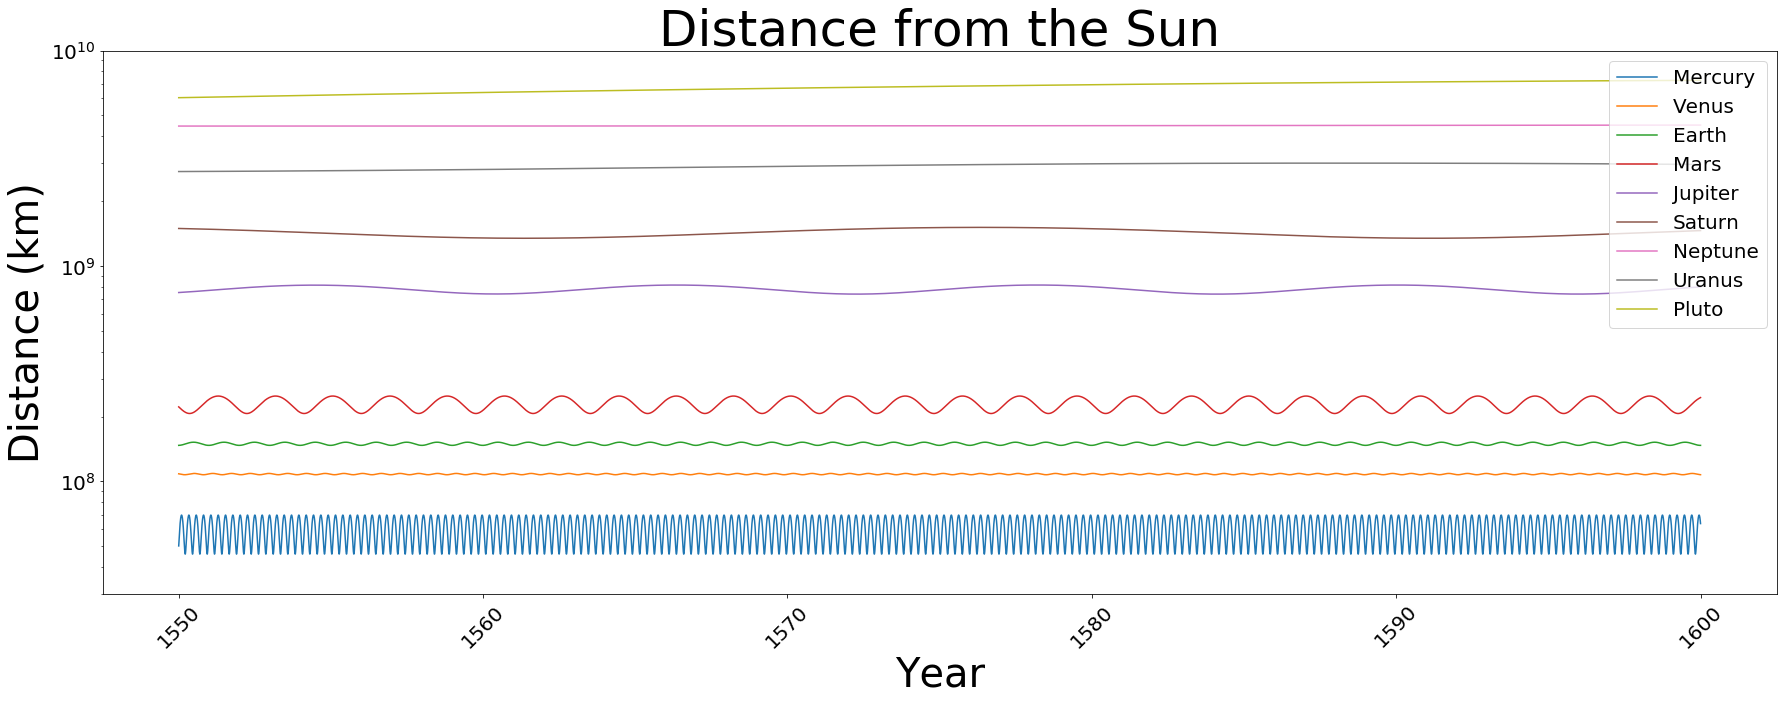

In [3]:
fig, ax = plt.subplots(figsize=(30, 10))
plt.xticks(rotation=45)

out_fp = "plot-distances_from_sun.png"
num_earth_years = 50
n = int(np.floor(num_earth_years * 365.25))
for celestial_obj in celestial_objects[1:]:
    x = dist_from_sun[celestial_obj]["DateTime"][:n]
    y = dist_from_sun[celestial_obj]["Distance (km)"][:n]

    ax.plot(x, y, label=celestial_obj)

ax.set_title("Distance from the Sun", fontsize=50)
ax.set_xlabel("Year", fontsize=40)
ax.set_ylabel("Distance (km)", fontsize=40)

ax.set_ylim([3e7, 1e10])
ax.set_yscale("log")
ax.tick_params(labelsize=20)
    
ax.legend(fontsize=20, loc="upper right")

plt.savefig(out_fp, dpi=300)

# Plot each celestial object's distance from Earth as a function of time

Let's focus on the celestial objects closest to Earth: the Sun, Mercury, Venus, and Mars.

Just like we expect, the Earth is *on average* closest to the Sun and then Mercury, Venus, and Mars. However, if we consider the closest approach to Earth (arguably the more relevant metric), we can see that Venus is closest.

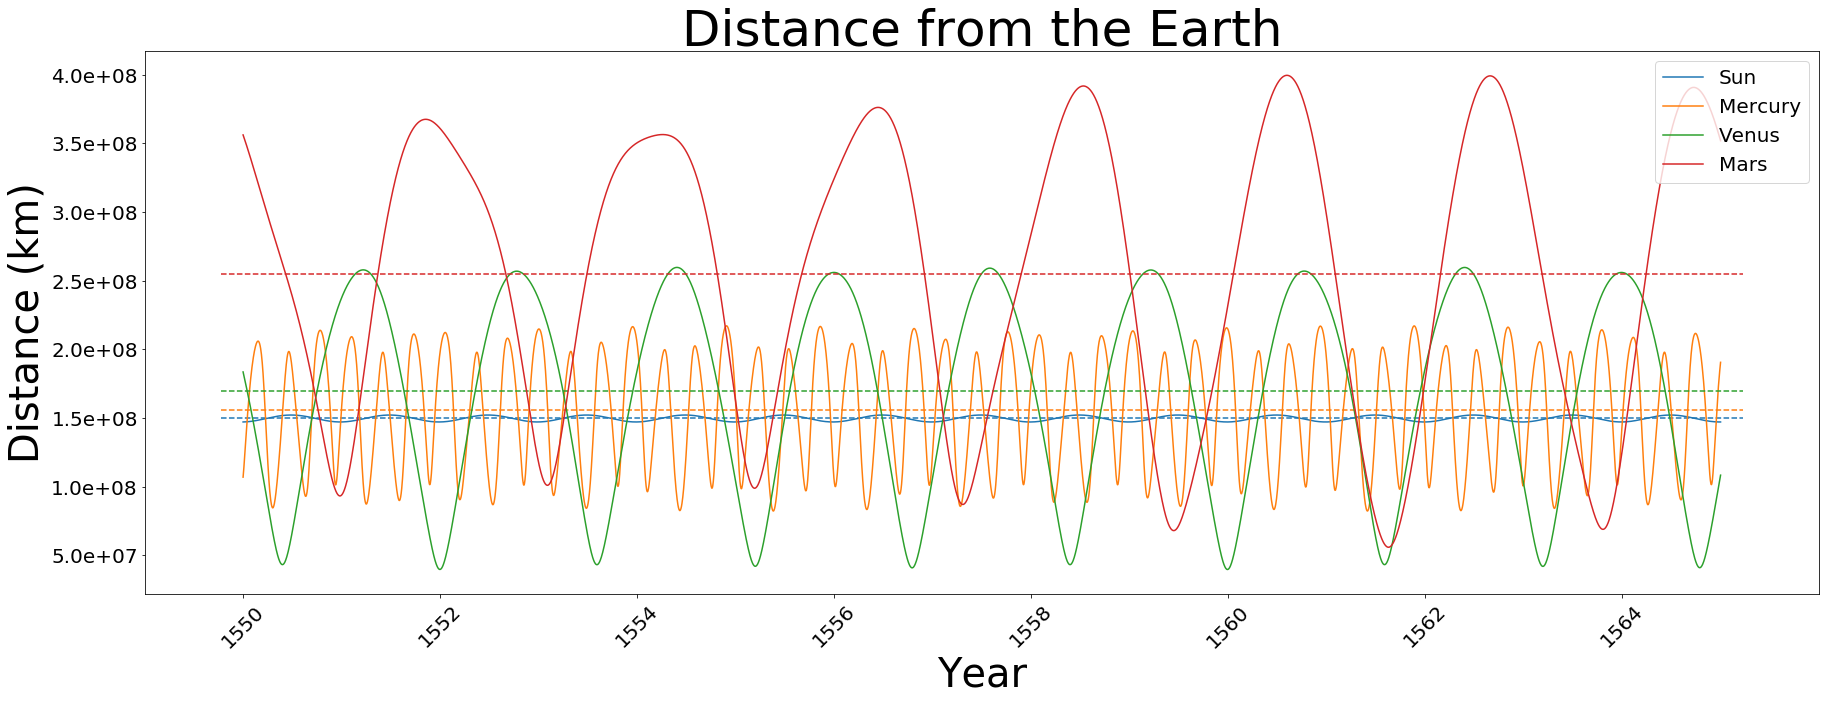

In [4]:
fig, ax = plt.subplots(figsize=(30, 10))
plt.xticks(rotation=45)

import matplotlib.cm

#%debug
out_fp = "plot-distances_from_earth.png"
num_earth_years = 15
n = int(np.floor(num_earth_years * 365.25))
for i, celestial_obj in enumerate(["Sun", "Mercury", "Venus", "Mars"]):
    # plot data
    x = dist_from_earth[celestial_obj]["DateTime"][:n]
    y = np.array(dist_from_earth[celestial_obj]["Distance (km)"][:n])
    
    ax.plot(x, y, label=celestial_obj, c=mpl.cm.tab10(i))
   
    # plot line showing average (extend line a little before/end of data for visibility)
    y_avg = np.mean(dist_from_earth[celestial_obj]["Distance (km)"])
    line_x = [x.iloc[0] - datetime.timedelta(days=0.015 * n), x.iloc[-1] + datetime.timedelta(days=0.015 * n)]
    line_y = [y_avg, y_avg]
    ax.plot(line_x, line_y, c=mpl.cm.tab10(i), linestyle="--")

ax.set_title("Distance from the Earth", fontsize=50)
ax.set_xlabel("Year", fontsize=40)
ax.set_ylabel("Distance (km)", fontsize=40)
ax.tick_params(labelsize=20)
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%1.1e"))

ax.legend(fontsize=20, loc="upper right")

plt.savefig(out_fp, dpi=300)

# Generate a heatmap for average pairwise distances between celestial objects

To give visual confirmation of what we've seen above.  The averages in this plot are for 992 years starting in 1550 and with pairwise distances calculated every 24 hours.

In [7]:
import csv

def parse_pairwise_distances_file(inp_fp):
    """
    Parse the CSV file with pairwise distances between celestial objects.
    
    Args:
        inp_fp (str): input file path
        
    Return:
        data (np.array): pairwise distances array
        labels (list<str>): labels for celestial objects
    """
    data = []
    with open(inp_fp, "r") as inp_file:
        csvreader = csv.reader(inp_file)
        labels = next(csvreader)[1:]
        for row in csvreader:
            data.append(list(map(float,row[1:])))
    data = np.array(data)
    
    return data, labels

### For all celestial objects

Note that I've chosen a log scale for the color map given the vastly different distances.

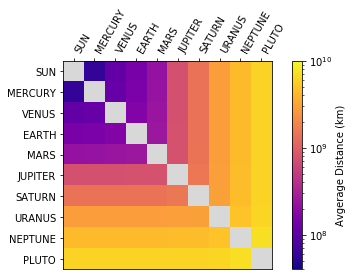

In [8]:
out_fp = "plot-pairwise_distances_heatmap-all.png"
inp_fp = os.path.join(inp_dir, "mean_pairwise_distances.csv")

# parse file with pairwise distances 
pdists, labels = parse_pairwise_distances_file(inp_fp)
nice_labels = [label if not label.endswith("_BARYCENTER") else label[:-11] for label in labels]

# plot it
fig, ax = plt.subplots()
ax.xaxis.tick_top()
plt.xticks(rotation=60, ha="left", va="bottom")

vmin = 4.0e7
vmax = 1.0e10
my_cmap = matplotlib.cm.get_cmap('plasma')
my_cmap.set_bad([0.85,]*3)
plt.imshow(pdists, origin="upper", norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax), cmap=my_cmap)


ax.set_xticks(np.arange(len(nice_labels)))
ax.set_yticks(np.arange(len(nice_labels)))
ax.set_xticklabels(nice_labels)
ax.set_yticklabels(nice_labels)

plt.colorbar(label="Avgerage Distance (km)")

fig.tight_layout()
plt.savefig(out_fp, dpi=300)

### For Sun, Mercury, Venus, Earth, and Mars

Note that this plot does **not** use a log scale for the color map.  Also, I had to use `set_under` rather than `set_bad` to color the distance $= 0$ grey.

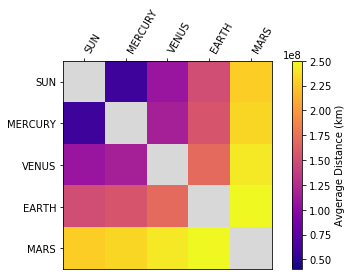

In [11]:
out_fp = "plot-pairwise_distances_heatmap-closest.png"
inp_fp = os.path.join(inp_dir, "mean_pairwise_distances.csv")

# parse file with pairwise distances 
pdists, labels = parse_pairwise_distances_file(inp_fp)
nice_labels = [label if not label.endswith("_BARYCENTER") else label[:-11] for label in labels]

pdists = pdists[:5,:5]
nice_labels = nice_labels[:5]


# plot it
fig, ax = plt.subplots()
ax.xaxis.tick_top()
plt.xticks(rotation=60, ha="left", va="bottom")

vmin = 4.0e7
vmax = 2.5e8
my_cmap = matplotlib.cm.get_cmap('plasma')
my_cmap.set_under([0.85,]*3)
plt.imshow(pdists, origin="upper", cmap=my_cmap, vmin=vmin, vmax=vmax)

ax.set_xticks(np.arange(len(nice_labels)))
ax.set_yticks(np.arange(len(nice_labels)))
ax.set_xticklabels(nice_labels)
ax.set_yticklabels(nice_labels)

plt.colorbar(label="Avgerage Distance (km)")

fig.tight_layout()
plt.savefig(out_fp, dpi=300)